In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.patches as mpatches
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PolyCollection
from matplotlib.gridspec import GridSpec

directory = 'C:/Users/U219200/OneDrive - IIASA/Projects/SM_AIRCO/data/'

In [41]:
def geopandas_colorbar_same_height(f, ax, vmin, vmax, cmap):

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    norm = Normalize(vmin=vmin, vmax=vmax)
    n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    n_cmap.set_array([])

    cbar = f.colorbar(n_cmap, cax=cax)
    cbar.ax.tick_params(labelsize=13) 
    

In [42]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.loc[world.name == 'Czechia', 'name'] = 'Czech Republic'
world.loc[world.name == 'United States of America','name'] = 'United States'
world.loc[world.name == 'Bosnia and Herz.', 'name'] = 'Bosnia and Herzegovina'
world.loc[world.name == 'S. Sudan', 'name'] = 'South Sudan'
world.loc[world.name == 'Dominican Rep.', 'name'] = 'Dominican Republic'
world.loc[world.name == 'Somaliland', 'name'] = 'Somalia'

world = world.set_index('name')

### Add the AC fraction to the map

In [43]:
dfgenb = pd.read_excel(directory+'global/genders_box_v2.xlsx').set_index('country')

In [44]:
dfgenb.head()

,Unnamed: 0,dau_audience,ac_fr_nov,ac_fr_spr,ac_fr_avg,genders
country,,,,,,
Central African Republic,Central African Republic,2697,0.078871,0.097701,0.088286,male
Nepal,Nepal,287397,0.054332,0.076471,0.065401,male
Italy,Italy,2002878,0.110778,0.042632,0.076705,male
Hungary,Hungary,428961,0.159261,0.323333,0.241297,male
Iraq,Iraq,1850406,0.130423,0.312500,0.221462,male


In [45]:
world['ac_fr'] = 100 * dfgenb[dfgenb['genders']=='both']['ac_fr_avg']
world.loc['Russia', 'ac_fr'] = 100 * 0.042221566 # ONly the Spring 2021 value, taken from russia_gender_cleaned.xlsx

In [46]:
len(world.index)

177

In [47]:
df_pen = pd.read_excel(directory+'GlobalPenetration.xlsx')
df_pen = df_pen.set_index('country')
world['penetration'] = df_pen['penetration'] * 100

In [48]:
to_drop = pd.read_excel(directory+'global/to_drop.xlsx')
to_drop = to_drop.set_index('country')

In [49]:
world.loc[world['penetration'].isna(), 'included'] = 0.5
for index, row in world.iterrows(): 
    if index in to_drop.index.tolist():
        world.loc[index, 'included'] = 0
    elif row['included'] != 0.5:
        world.loc[index, 'included'] = 1

### Gender, age and education

In [50]:
#dfgenb = dfgen[dfgen['interest_name']=='Air conditioning'][['genders', 'ac_fr']]
dfgenb = dfgenb[~dfgenb.index.isin(to_drop.index)]
dfgenb['ac_fr'] = 100 * dfgenb['ac_fr_avg']
dfgenb.loc[dfgenb["ac_fr_avg"]==np.inf, "ac_fr"] = dfgenb.loc[dfgenb["ac_fr_avg"]==np.inf, "ac_fr_spr"]


dfageb = pd.read_excel(directory+'global/ages_box_v2.xlsx')
dfageb = dfageb.set_index('country')
dfageb = dfageb[dfageb['ac_fr_avg']<=1]
dfageb = dfageb[~dfageb.index.isin(to_drop.index)]
dfageb['ac_fr'] = 100 * dfageb['ac_fr_avg']
dfageb.loc[dfageb["ac_fr_avg"]==np.inf, "ac_fr"] = dfageb.loc[dfageb["ac_fr_avg"]==np.inf, "ac_fr_spr"]

dfedub = pd.read_excel(directory+'global/edu_box_v2.xlsx')
dfedub = dfedub.set_index('country')
dfedub = dfedub[dfedub['ac_fr_avg']<=1]
dfedub = dfedub[~dfedub.index.isin(to_drop.index)]
dfedub['ac_fr'] = 100 * dfedub['ac_fr_avg']
dfedub = dfedub.sort_index()
dfedub.loc[dfedub["ac_fr_avg"]==np.inf, "ac_fr"] = dfedub.loc[dfedub["ac_fr_avg"]==np.inf, "ac_fr_spr"]

dfrelb = pd.read_excel(directory+'global/relationship_box_v2.xlsx')
dfrelb = dfrelb.set_index('country')
dfrelb = dfrelb[dfrelb['ac_fr_avg']<=1]
dfrelb = dfrelb[~dfrelb.index.isin(to_drop.index)]
dfrelb['ac_fr'] = 100 * dfrelb['ac_fr_avg']
dfrelb = dfrelb.sort_index()
dfrelb.loc[dfrelb["ac_fr_avg"]==np.inf, "ac_fr"] = dfrelb.loc[dfrelb["ac_fr_avg"]==np.inf, "ac_fr_spr"]

dffamb = pd.read_excel(directory+'global/family_box_v2.xlsx')
dffamb = dffamb.set_index('country')
dffamb = dffamb[dffamb['ac_fr_avg']<=1]
dffamb = dffamb[~dffamb.index.isin(to_drop.index)]
dffamb['ac_fr'] = 100 * dffamb['ac_fr_avg']
dffamb = dffamb.sort_index()
dffamb.loc[dffamb["ac_fr_avg"]==np.inf, "ac_fr"] = dffamb.loc[dffamb["ac_fr_avg"]==np.inf, "ac_fr_spr"]

In [51]:
fam_index = dffamb[(dffamb['family_statuses']!='all family')&(dffamb['dau_audience']>1000)].index.drop_duplicates()
print(dffamb.shape)                  
dffamb = dffamb.loc[fam_index]
dffamb.shape

(327, 7)


(280, 7)

In [52]:
dffamb['family_statuses'].replace(to_replace='all family', value='all', inplace=True)

In [53]:
# add a global nort- south tag to all dfs
df_regions = pd.read_excel(directory+'global/regions.xlsx')
df_regions = df_regions.set_index('name')

dfgenb['region'] = df_regions['tag']
dfageb['region'] = df_regions['tag']
dfedub['region'] = df_regions['tag']
dfrelb['region'] = df_regions['tag']
dffamb['region'] = df_regions['tag']

In [54]:
# global statistics on average values

df_stat = pd.DataFrame()
i=0
att_dic = {'genders' : dfgenb,
          'ages_ranges' : dfageb,
          'scholarities' : dfedub,
          'relationship_statuses' : dfrelb,
           'family_statuses' : dffamb
          }
for attribute, dfd in att_dic.items():
    att_list = list(set(dfd[attribute]))
    for region in ['north', 'south', 'all']:
        if region == 'all':
            dfs = dfd
        else:
            dfs = dfd[dfd['region']==region]
        for atti in att_list:
            df_stat.loc[i, 'attribute'] = attribute
            df_stat.loc[i, 'range'] = atti
            df_stat.loc[i, 'region'] = region
            df_stat.loc[i, 'mean'] = dfs[dfs[attribute]==atti]['ac_fr'].mean()
            df_stat.loc[i, 'median'] = dfs[dfs[attribute]==atti]['ac_fr'].median()
            df_stat.loc[i, 'q25'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.25)
            df_stat.loc[i, 'q75'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.75)
            df_stat.loc[i, 'std'] = dfs[dfs[attribute]==atti]['ac_fr'].std()
            df_stat.loc[i, 'n'] = dfs[dfs[attribute]==atti]['ac_fr'].shape[0]
        
            i += 1

#df_stat.to_excel(directory+'global_stats_season_avg.xlsx')

In [55]:
df_stat[df_stat['attribute']=='family_statuses']['range'].replace(to_replace='all family', value='all',inplace=True)
#df_stat[(df_stat['attribute']=='family_statuses')&(df_stat['range']=='all')]['mean'] = dffamb
#df_stat[(df_stat['attribute']=='family_statuses')&(df_stat['range']=='parents of 0-8 yrs old')]['mean'] 
#df_stat[(df_stat['attribute']=='family_statuses')&(df_stat['range']=='parents of 9-18 yrs old')]['mean']

C:\Users\U219200\AppData\Local\Temp\ipykernel_20932\3316060037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat[df_stat['attribute']=='family_statuses']['range'].replace(to_replace='all family', value='all',inplace=True)


In [56]:
world[world['included']==1].shape

(113, 8)

In [57]:
world[world['included']==0.5].shape

(45, 8)

In [64]:
color_dic = {'north' : sns.color_palette('pastel')[0],
             'south' : sns.color_palette('pastel')[3]}

cmap = mpl.cm.twilight(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[15:85,:-1])

def plot_the_map(axbig):
    axbig.set_title("(A) Air-conditioning interest of the social media audience across the world", fontweight='bold', fontsize=15)
    axbig.set_xlim([-175, 175])
    axbig.set_ylim([-60,75])
    axbig.grid(False)
    axbig.set_xticks([])
    axbig.set_yticks([])

    # included
    world[world['included']==1].plot(ax=axbig, column='ac_fr', cmap=cmap)
    # no data
    world[world['included']==0.5].plot(ax=axbig, color='beige')
    # dropped
    world[world['included']==0].plot(ax=axbig, color='lightgrey')
    geopandas_colorbar_same_height(fig, axbig, 0, 55, cmap)
    
    axbig.set_axis_off()

    # make legend with patches
    beige = mpatches.Patch(color='beige', label='no data')
    grey = mpatches.Patch(color='lightgrey', label='low penetration')
    axbig.legend(handles=[beige, grey], ncol=1, loc='lower left', fontsize=12)
    
def plot_violin(ax, df, attribute, title):
    df = df.sort_values(['region', attribute])
    ax = sns.violinplot(x=attribute ,y="ac_fr", data=df, cut=0, hue='region', split=True, palette=color_dic, 
                               ax=ax, linewidth=2.5, inner='box')
    if attribute=='genders':
        ax.set_ylabel("Audience % interested\nin air-conditioning", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.set_title(title, fontweight='bold', fontsize=15)
    ax.set_xlabel("")
    if attribute in ['genders', 'age']:
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=90)
    elif attribute=='scholarities':
        ax.set_xticklabels(['< high school', 'High school', 'Bachelors', 'Higher'], fontsize=12, rotation=90)
    elif attribute=='relationship_statuses':
        ax.set_xticklabels(['All', 'Married or cohab.'], fontsize=12, rotation=45)
    elif attribute == 'family_statuses':
        ax.set_xticklabels(['All', '0-8 yrs old', '9-18 yrs old'], fontsize=12, rotation=45)
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor('lightgrey')
            art.set_linewidth(0.25)

    categories = sorted(list(set(df[attribute])))
    xs = range(len(categories))
    ys_north = []
    ys_south = []
    ys = []
    for category in categories:
        if attribute != 'family_statuses':
            ys.append(df_stat[(df_stat['attribute']==attribute)&(df_stat['range']==category)&(df_stat['region']=='all')]['mean'])
            ys_north.append(df_stat[(df_stat['attribute']==attribute)&(df_stat['range']==category)&(df_stat['region']=='north')]['mean'])
            ys_south.append(df_stat[(df_stat['attribute']==attribute)&(df_stat['range']==category)&(df_stat['region']=='south')]['mean'])
        else:
            ys.append(dffamb[dffamb['family_statuses']==category]['ac_fr'].mean())
            ys_north.append(dffamb[(dffamb['family_statuses']==category)&(dffamb['region']=='north')]['ac_fr'].mean())
            ys_south.append(dffamb[(dffamb['family_statuses']==category)&(dffamb['region']=='south')]['ac_fr'].mean())
    ax.plot(xs, ys, color='grey', linestyle='-')
    ax.plot(xs, ys_north, color=color_dic['north'], linestyle='--', lw=2)
    ax.plot(xs, ys_south, color=color_dic['south'], linestyle='--', lw=2)
    ax.get_legend().remove()
    

In [59]:
df_macro = pd.read_excel('C:/Users/U219200/IIASA/ECE.prog - social media study/cdd_sm_sales.xlsx')

df_macro.replace(to_replace='United States of America', value='United States', inplace=True)
df_macro.set_index('Unnamed: 0', inplace=True)
df_macro = df_macro[['country', 'cdd', 'gdp pc', 'ac_fr']]
df_macro['region'] = df_regions['tag']
for cnt in ['India', 'Mexico', 'Brazil', 'United States']:
    df_macro.loc[df_macro['country']==cnt, 'region'] = df_regions.loc[cnt, 'tag']

In [60]:
df_macro.tail()

,country,cdd,gdp pc,ac_fr,region
Unnamed: 0,,,,,
French Guiana,NaN,117.0,NaN,NaN,south
South Sudan,NaN,846.0,NaN,0.057778,south
Western Sahara,NaN,462.0,NaN,NaN,south
Greenland,NaN,0.0,NaN,NaN,NaN
North Korea,NaN,2.0,NaN,NaN,NaN


In [61]:
df_macro.loc['United States',]

country        NaN
cdd           50.0
gdp pc     65280.0
ac_fr        0.092
region       north
Name: United States, dtype: object

In [62]:
# replace df_macro with new data (avg of two seasons)
dd = dfgenb[dfgenb['genders']=='both']
for index, row in dd.iterrows():
    if index in df_macro.index:
        df_macro.loc[index, 'ac_fr'] = dd.loc[index,'ac_fr_avg']
df_macro.head()

,country,cdd,gdp pc,ac_fr,region
Unnamed: 0,,,,,
Andaman and Nicobar,India,0.0,NaN,0.019762,south
Andhra Pradesh,India,191.0,8261.0,0.034984,south
Arunachal Pradesh,India,0.0,7628.0,0.021158,south
Assam,India,4.0,4485.0,0.020390,south
Bihar,India,118.0,2395.0,0.021289,south


In [63]:
def plot_hued_regression(ax, df, attribute, title):
    df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
    #df = df[df['gdp pc']<203000]
    xmax = df[attribute].max()
    xmin = df[attribute].min()
    
    for region, color in color_dic.items():
        print(attribute, region, xmax, xmin)
        dfp = df[df['region']==region].copy()
        n = dfp.shape[0]
        
        #normalize
        dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
        dfp['ac_fr'] = 100 * dfp['ac_fr']
        
        # remove the outliers for GDP
        #if attribute == 'gdp pc':
        #    dfp = dfp[dfp['x']<=0.6]
        #    dfp = dfp[dfp['ac_fr']<=40]
                  
        #regression
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(dfp['x'],
                                                                   dfp['ac_fr'])
        ax = sns.regplot(x='x', y='ac_fr', data=dfp, ax=ax, color=color,
                      line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},
                     scatter_kws={'s' : 50})
        # legend
        ax.legend(loc='upper right')
        if region=='north':
            ax.annotate("N = {0:.0f}".format(n), (0.39, 50), fontsize=10, color=color_dic['north'], fontweight='bold')
            ax.annotate("r = {0:.2f}".format(r_value), (.39, 43), fontsize=10, color=color_dic['north'], fontweight='bold')
            ax.annotate("p = {0:.3f}".format(p_value), (.39, 36), fontsize=10, color=color_dic['north'], fontweight='bold')
        else:
            ax.annotate("N = {0:.0f}".format(n), (0.54, 50), fontsize=10, color=color_dic['south'], fontweight='bold')
            ax.annotate("r = {0:.2f}".format(r_value), (.54, 43), fontsize=10, color=color_dic['south'], fontweight='bold')
            ax.annotate("p = {0:.3f}".format(p_value), (.54, 36), fontsize=10, color=color_dic['south'], fontweight='bold')
        
    ax.set_title(title, fontweight='bold', fontsize=15)
    if attribute == 'gdp pc':
        ax.set_ylabel("Audience % interested\nin air-conditioning", fontsize=12)
        ax.set_xlabel("Normalized GDP per capita")
    else:
        ax.set_ylabel("")
        ax.set_xlabel("Normalized CDD")
    return ax, dfp
    

gdp pc north 203173.0 411.0
gdp pc south 203173.0 411.0
cdd north 1528.0 0.0
cdd south 1528.0 0.0


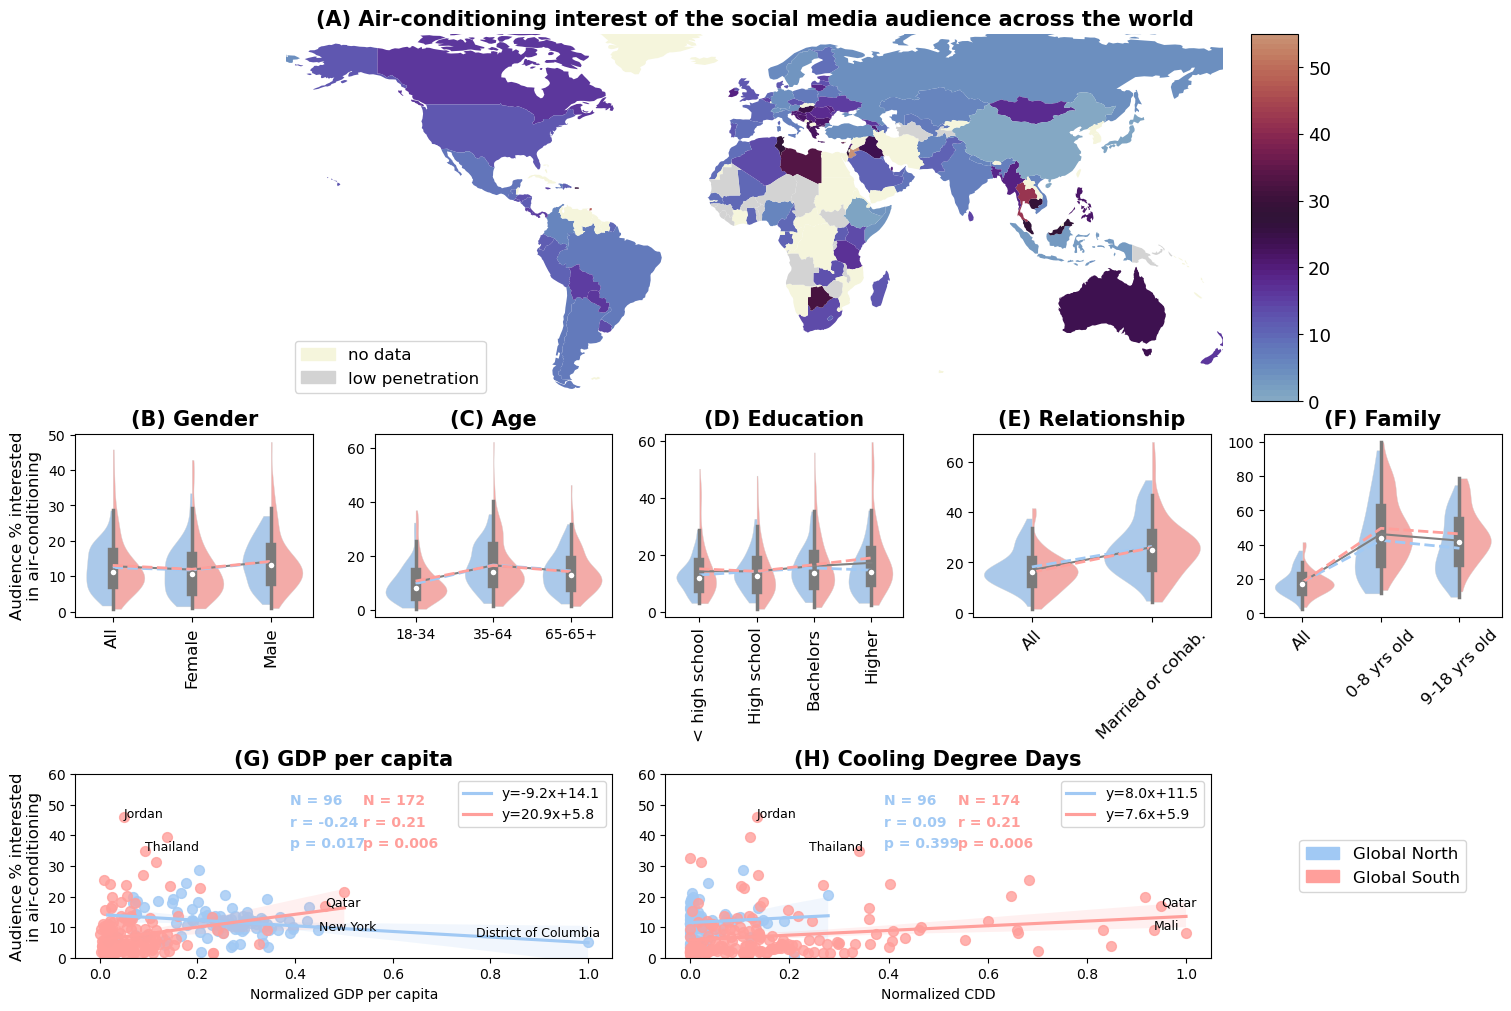

In [66]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(15,10)
gs = GridSpec(3, 5, figure=fig, height_ratios=[2,1,1])
axbig = fig.add_subplot(gs[0, :])
axes5 = [fig.add_subplot(gs[1, i]) for i in range(5)]
ax6 = fig.add_subplot(gs[2, :2]) 
ax7 = fig.add_subplot(gs[2, 2:4]) 
axleg = fig.add_subplot(gs[2, -1])
axleg.set_axis_off()

### a) map
plot_the_map(axbig)

### b) gender
plot_violin(axes5[0], dfgenb, 'genders', "(B) Gender")
axes5[0].set_xticklabels(['All', 'Female', 'Male'], fontsize=12, rotation=90)

### c) age
plot_violin(axes5[1], dfageb, 'ages_ranges', "(C) Age")

### d) education
plot_violin(axes5[2], dfedub, 'scholarities', "(D) Education")

### e) relationship
plot_violin(axes5[3], dfrelb, 'relationship_statuses', "(E) Relationship")

### f) family
plot_violin(axes5[4], dffamb, 'family_statuses', "(F) Family")

### g) social media vs. gdp per capita - ax6

ax6, dfp = plot_hued_regression(ax6, df_macro, 'gdp pc', '(G) GDP per capita')
ax6.annotate("Jordan", (dfp.loc['Jordan', 'x'],dfp.loc['Jordan', 'ac_fr']), fontsize=9)
ax6.annotate("Thailand", (dfp.loc['Thailand', 'x'],dfp.loc['Thailand', 'ac_fr']), fontsize=9)
ax6.annotate("Qatar", (dfp.loc['Qatar', 'x'],dfp.loc['Qatar', 'ac_fr']), fontsize=9)
ax6.annotate("District of Columbia", (0.77,7), fontsize=9)
ax6.annotate("New York", (91102/203173,8.9), fontsize=9)
ax6.set_ylim([0, 60])
### h) social media vs. CDD - ax7
ax7, dfp = plot_hued_regression(ax7, df_macro, 'cdd', '(H) Cooling Degree Days')
ax7.annotate("Qatar", (dfp.loc['Qatar', 'x'],dfp.loc['Qatar', 'ac_fr']), fontsize=9)
ax7.annotate("Mali", (dfp.loc['Mali', 'x'],dfp.loc['Mali', 'ac_fr']), fontsize=9)
ax7.annotate("Jordan", (dfp.loc['Jordan', 'x'],dfp.loc['Jordan', 'ac_fr']), fontsize=9)
ax7.annotate("Thailand", (dfp.loc['Thailand', 'x']-0.1,dfp.loc['Thailand', 'ac_fr']), fontsize=9)
ax7.set_ylim([0, 60])
# make legend with patches
north = mpatches.Patch(color=color_dic['north'], label='Global North')
south = mpatches.Patch(color=color_dic['south'], label='Global South')
axleg.legend(handles=[north, south], ncol=1, loc='center', fontsize=12)

plt.savefig(directory+"global/Fig3_globalSM_v3.pdf", dpi=600, bbox_inches='tight')

north 0.21348167539266996 24.77948322822923
south 0.9397513089005237 36.151379543186145


C:\Users\U219200\AppData\Local\Temp\ipykernel_12248\2187387316.py:16: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x='x', y='ac_fr', data=dfp, ax=ax, color=color,)
C:\Users\U219200\AppData\Local\Temp\ipykernel_12248\2187387316.py:16: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x='x', y='ac_fr', data=dfp, ax=ax, color=color,)


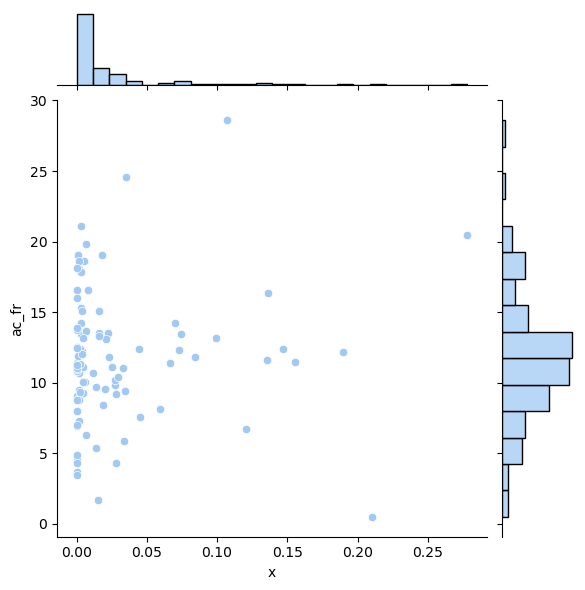

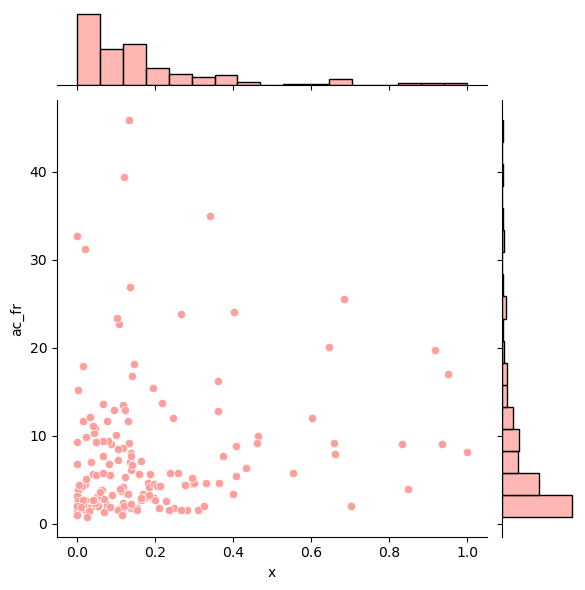

In [182]:
# excluding outliers
attribute = 'cdd'
df = df_macro.copy()
df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
xmax = df[attribute].max()
xmin = df[attribute].min()
for region, color in color_dic.items():
    dfp = df[df['region']==region].copy()
    
    #normalize
    dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
    dfp['ac_fr'] = 100 * dfp['ac_fr']
    
    print(region, dfp['x'].quantile(0.99), dfp['ac_fr'].quantile(.99))

    sns.jointplot(x='x', y='ac_fr', data=dfp, ax=ax, color=color,)


north 0.21348167539266996 24.77948322822923
           country    cdd   gdp pc      ac_fr region         x
Unnamed: 0                                                    
Australia      NaN  425.0  52203.0  20.439764  north  0.278141
           country    cdd   gdp pc      ac_fr region        x
Unnamed: 0                                                   
Cyprus         NaN  164.0  41515.0  28.608619  north  0.10733
south 0.9397513089005237 36.151379543186145
           country     cdd   gdp pc      ac_fr region         x
Unnamed: 0                                                     
Kuwait         NaN  1528.0  51364.0   8.114492  south  1.000000
Qatar          NaN  1452.0  93852.0  17.003595  south  0.950262
                    country    cdd   gdp pc      ac_fr region         x
Unnamed: 0                                                             
Jordan                  NaN  205.0  10497.0  45.838415  south  0.134162
Trinidad and Tobago     NaN  184.0  28151.0  39.408020  south  0.

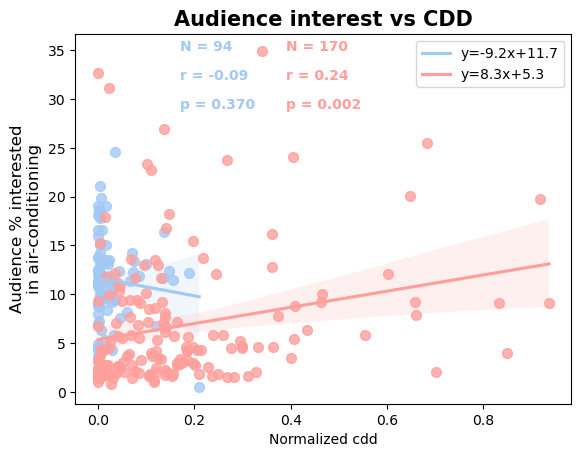

In [200]:
attribute = 'cdd'

df = df_macro.copy()
df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
xmax = df[attribute].max()
xmin = df[attribute].min()

limits = {'north' : (0.6, 22),
          'south' : (0.4, 30)}
fig, ax = plt.subplots()
for region, color in color_dic.items():
    dfp = df[df['region']==region].copy()
    

    #normalize
    dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
    dfp['ac_fr'] = 100 * dfp['ac_fr']
    
    # remove the outliers for GDP
    l1 = dfp['x'].quantile(0.99)
    l2 = dfp['ac_fr'].quantile(.99)
    IQRx =  dfp['x'].quantile(0.75) - dfp['x'].quantile(0.25)
    IQRy =  dfp['ac_fr'].quantile(0.75) - dfp['ac_fr'].quantile(0.25)
    #l1 = dfp['x'].quantile(0.75) + 1.5 * IQRx
    #l2 = dfp['ac_fr'].quantile(0.75) + 1.5 * IQRy
    print(region, l1, l2)
    print(dfp[dfp['x']>l1])
    print(dfp[dfp['ac_fr']>l2])
    dfp = dfp[dfp['x']<=l1]
    dfp = dfp[dfp['ac_fr']<=l2]
    n = dfp.shape[0]
    #regression

    slope, intercept, r_value, p_value, std_err = stats.linregress(dfp['x'],
                                                               dfp['ac_fr'])
    ax = sns.regplot(x='x', y='ac_fr', data=dfp, ax=ax, color=color,
                  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},
                 scatter_kws={'s' : 50})
    # legend
    ax.legend(loc='upper right')
    if region=='north':
        ax.annotate("N = {0:.0f}".format(n), (0.17, 35), fontsize=10, color=color_dic['north'], fontweight='bold')
        ax.annotate("r = {0:.2f}".format(r_value), (.17, 32), fontsize=10, color=color_dic['north'], fontweight='bold')
        ax.annotate("p = {0:.3f}".format(p_value), (.17, 29), fontsize=10, color=color_dic['north'], fontweight='bold')
    else:
        ax.annotate("N = {0:.0f}".format(n), (0.39, 35), fontsize=10, color=color_dic['south'], fontweight='bold')
        ax.annotate("r = {0:.2f}".format(r_value), (.39, 32), fontsize=10, color=color_dic['south'], fontweight='bold')
        ax.annotate("p = {0:.3f}".format(p_value), (.39, 29), fontsize=10, color=color_dic['south'], fontweight='bold')

ax.set_title("Audience interest vs CDD", fontweight='bold', fontsize=15)
ax.set_ylabel("Audience % interested\nin air-conditioning", fontsize=12)
ax.set_xlabel("Normalized cdd")

plt.savefig(directory+"global/cdd_outliers_rmemoved.png", dpi=600, bbox_inches='tight')

In [66]:
dfageb[(dfageb['region']=='north')&(dfageb['ages_ranges']=='65-65+')&(dfageb['ac_fr']>25)]

,ages_ranges,dau_audience,mau_audience,ac_fr,region
country,,,,,
Cyprus,65-65+,20262,22000,33.846154,north
Greece,65-65+,111616,130000,30.952381,north
Croatia,65-65+,31117,36000,27.692308,north
Hungary,65-65+,185803,210000,32.812500,north


In [68]:
set(df_macro.country)

{'Brazil', 'India', 'Mexico', 'United States', nan}

In [69]:
df_macro.shape

(335, 5)

In [70]:
df_macro[df_macro['country'].isna()].shape

(189, 5)

In [71]:
for cnt in list(set(df_macro.country)):
    if cnt:
        print(cnt, df_macro[df_macro['country']==cnt].shape)

nan (0, 5)
Brazil (27, 5)
Mexico (32, 5)
United States (51, 5)
India (36, 5)


In [79]:
df_macro[(df_macro['country'].isna())&(~df_macro['ac_fr'].isna())].index

Index(['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Burundi',
       ...
       'Uganda', 'Ukraine', 'Uruguay', 'United States of America',
       'Uzbekistan', 'Viet Nam', 'South Africa', 'Zambia', 'Zimbabwe',
       'South Sudan'],
      dtype='object', name='Unnamed: 0', length=135)

In [91]:
sth_ = df_regions[df_regions['tag']=='south'].index
string = []
for cnt in sth_:
    string.append(cnt)
string = ', '.join(string)
print(string)

Angola, Burundi, Benin, Burkina Faso, Botswana, Central African Republic, Cote d'Ivoir, Cameroon, Democratic Republic of the Congo, Congo, Comoros, Cape Verde, Djibouti, Eritrea, Western Sahara, Ethiopia, Gabon, Ghana, Guinea, Gambia, Guinea-Bissau, Equatorial Guinea, Kenya, Liberia, Lesotho, Madagascar, Mali, Mozambique, Mauritania, Mauritius, Malawi, Namibia, Niger, Nigeria, Rwanda, Senegal, Sierra Leone, Somalia, Swaziland, Seychelles, Chad, Togo, Tanzania, Uganda, South Africa, Zambia, Zimbabwe, China, Cambodia, Lao People's Democratic Republic, Mongolia, Dem People's Rep of Korea, Vietnam, Argentina, Antigua and Barbuda, Belize, Bolivia, Brazil, Barbados, Chile, Colombia, Costa Rica, Cuba, Dominica, Dominican Republic, Ecuador, Grenada, Guatemala, French Guiana, Guyana, Honduras, Haiti, Jamaica, Saint Kitts and Nevis, Saint Lucia, Mexico, Nicaragua, Panama, Peru, Paraguay, El Salvador, Sao Tome and Principe, Suriname, Trinidad and Tobago, Uruguay, Saint Vincent and the Grenadines,

In [127]:
a = df_macro[df_macro['region']=='north'][['gdp pc', 'ac_fr']].dropna().sort_values(by='gdp pc')

# SELECTED REGIONS

In [17]:
dfgenb['subregion'] = df_regions['region_gea']
dfageb['subregion'] = df_regions['region_gea']
dfedub['subregion'] = df_regions['region_gea']
dfrelb['subregion'] = df_regions['region_gea']
dffamb['subregion'] = df_regions['region_gea']
#df_macro['subregion'] = df_regions['region_gea']

In [18]:
dfgenb2 = dfgenb[dfgenb['subregion'].isin(['EEU', 'MEA', 'PAS', 'AFR'])]
dfageb2 = dfageb[dfageb['subregion'].isin(['EEU', 'MEA', 'PAS', 'AFR'])]
dfedub2 = dfedub[dfedub['subregion'].isin(['EEU', 'MEA', 'PAS', 'AFR'])]
dfrelb2 = dfrelb[dfrelb['subregion'].isin(['EEU', 'MEA', 'PAS', 'AFR'])]
dffamb2 = dffamb[dffamb['subregion'].isin(['EEU', 'MEA', 'PAS', 'AFR'])]
#dfmac2 = df_macro[df_macro['subregion'].isin(['EEU', 'MEA', 'PAS'])]

In [139]:
dfmac2['subregion'].to_excel(directory+'global/focus_countries.xlsx')

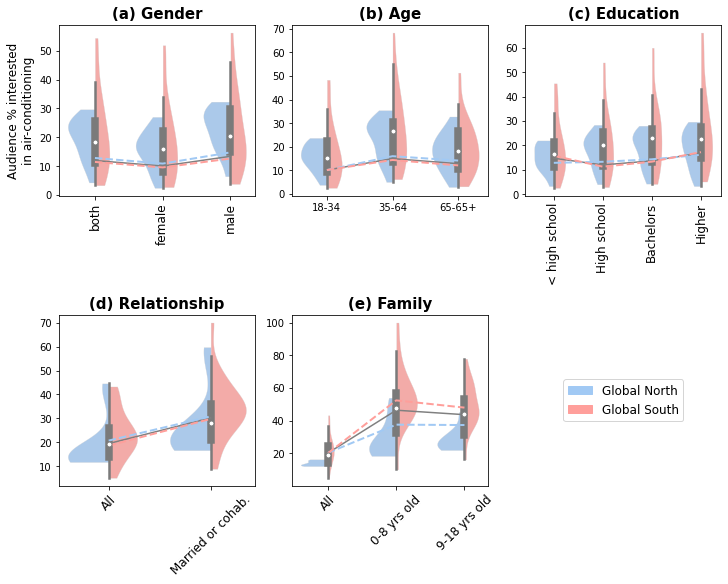

In [157]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10,8)
gs = GridSpec(2, 3, figure=fig,)
axes3 = [fig.add_subplot(gs[0, i]) for i in range(3)]
axes2 = [fig.add_subplot(gs[1, i]) for i in range(2)]
axleg = fig.add_subplot(gs[1, -1])
axleg.set_axis_off()

### b) gender
plot_violin(axes3[0], dfgenb2, 'genders', "(a) Gender")
axes5[0].set_xticklabels(['All', 'Female', 'Male'], fontsize=12, rotation=90)

### c) age
plot_violin(axes3[1], dfageb2, 'ages_ranges', "(b) Age")

### d) education
plot_violin(axes3[2], dfedub2, 'scholarities', "(c) Education")

### e) relationship
plot_violin(axes2[0], dfrelb2, 'relationship_statuses', "(d) Relationship")

### f) family
plot_violin(axes2[1], dffamb2, 'family_statuses', "(e) Family")

# make legend with patches
north = mpatches.Patch(color=color_dic['north'], label='Global North')
south = mpatches.Patch(color=color_dic['south'], label='Global South')
axleg.legend(handles=[north, south], ncol=1, loc='center', fontsize=12)

#plt.savefig(directory+"global/Fig3_globalSM.png", dpi=600, bbox_inches='tight')

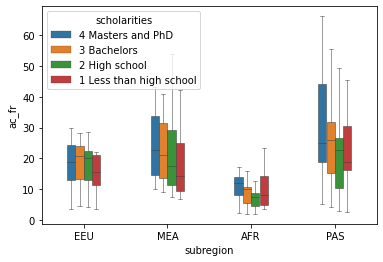

In [18]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="subregion", y="ac_fr", data=dfedub2, hue='scholarities', width=0.4, linewidth=0.5, fliersize=0)
#ax = sns.swarmplot(x="scholarities", y="ac_fr", hue="subregion", data=dfedub2, palette='Set2')
#ax = sns.violinplot(x="subregion", y="ac_fr", hue="scholarities", data=dfedub2, palette='Set2', cut=0, )
plt.show()

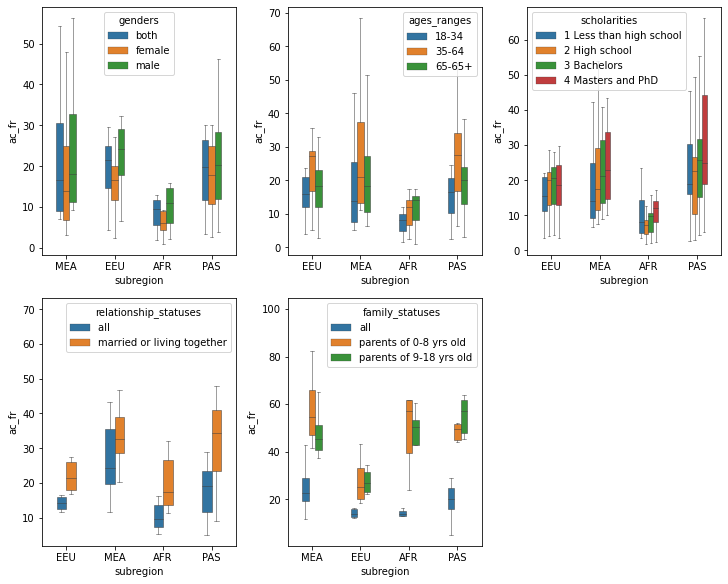

In [19]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10,8)
gs = GridSpec(2, 3, figure=fig,)
axes3 = [fig.add_subplot(gs[0, i]) for i in range(3)]
axes2 = [fig.add_subplot(gs[1, i]) for i in range(2)]
axleg = fig.add_subplot(gs[1, -1])
axleg.set_axis_off()

axes3[0] = sns.boxplot(x="subregion", y="ac_fr", data=dfgenb2, hue='genders', hue_order=['both', 'female', 'male'], 
                       width=0.4, linewidth=0.5, fliersize=0, ax=axes3[0])

axes3[1] = sns.boxplot(x="subregion", y="ac_fr", data=dfageb2, hue='ages_ranges', hue_order=['18-34', '35-64', '65-65+'],
                       width=0.4, linewidth=0.5, fliersize=0, ax=axes3[1])

axes3[2] = sns.boxplot(x="subregion", y="ac_fr", data=dfedub2, hue='scholarities', hue_order=['1 Less than high school', '2 High school', '3 Bachelors', '4 Masters and PhD'],
                       width=0.4, linewidth=0.5, fliersize=0, ax=axes3[2])

axes2[0] = sns.boxplot(x="subregion", y="ac_fr", data=dfrelb2, hue='relationship_statuses', 
                       width=0.4, linewidth=0.5, fliersize=0, ax=axes2[0])

axes2[1] = sns.boxplot(x="subregion", y="ac_fr", data=dffamb2, hue='family_statuses', hue_order=['all','parents of 0-8 yrs old','parents of 9-18 yrs old'],
                       width=0.4, linewidth=0.5, fliersize=0, ax=axes2[1])

plt.show()

In [54]:
dfageb2[(dfageb2['subregion']=='AFR')&(dfageb2['ages_ranges']=='65-65+')]['ac_fr'].mean()

12.475271391577177

In [28]:
dfgenb2 = dfgenb2.sort_values(by='genders', ascending=True)
dfageb2 = dfageb2.sort_values(by='ages_ranges', ascending=True)
dfedub2 = dfedub2.sort_values(by='scholarities', ascending=True)
dfrelb2 = dfrelb2.sort_values(by='relationship_statuses', ascending=True)
dffamb2.replace(to_replace=' all', value='all')
dffamb2 = dffamb2.sort_values(by='family_statuses', ascending=True)

dfs = {'genders'      : (dfgenb2, 'Gender'),
       'ages_ranges'  : (dfageb2, 'Age'),
       'scholarities' : (dfedub2, 'Education'),
       'relationship_statuses' : (dfrelb2, 'Relationship'),
       'family_statuses' : (dffamb2, 'Family')
      }

In [21]:
df_stat2 = pd.DataFrame()
i=0
att_dic = {'genders' : dfgenb2,
          'ages_ranges' : dfageb2,
          'scholarities' : dfedub2,
          'relationship_statuses' : dfrelb2,
           'family_statuses' : dffamb2
          }
for attribute, dfd in att_dic.items():
    att_list = list(set(dfd[attribute]))
    for region in ['EEU', 'PAS', 'MEA', 'AFR']:
        dfs = dfd[dfd['subregion']==region]
        for atti in att_list:
            df_stat2.loc[i, 'attribute'] = attribute
            df_stat2.loc[i, 'range'] = atti
            df_stat2.loc[i, 'region'] = region
            df_stat2.loc[i, 'mean'] = dfs[dfs[attribute]==atti]['ac_fr'].mean()
            df_stat2.loc[i, 'median'] = dfs[dfs[attribute]==atti]['ac_fr'].median()
            df_stat2.loc[i, 'q25'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.25)
            df_stat2.loc[i, 'q75'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.75)
            df_stat2.loc[i, 'std'] = dfs[dfs[attribute]==atti]['ac_fr'].std()
            df_stat2.loc[i, 'n'] = dfs[dfs[attribute]==atti]['ac_fr'].shape[0]
        
            i += 1

In [189]:
df_stat2.to_excel(directory+'global/4_regions_stats_v2.xlsx')

C:\Users\U219200\AppData\Local\Temp\ipykernel_20932\3192185824.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_yticklabels([0, 10, 20, 30 ,40])
C:\Users\U219200\AppData\Local\Temp\ipykernel_20932\3192185824.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_yticklabels([0, 10, 20, 30 ,40, 50,60])
C:\Users\U219200\AppData\Local\Temp\ipykernel_20932\3192185824.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_yticklabels([0, 10, 20, 30 ,40, 50,60])
C:\Users\U219200\AppData\Local\Temp\ipykernel_20932\3192185824.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_yticklabels([0, 10, 20, 30 ,40, 50,60])


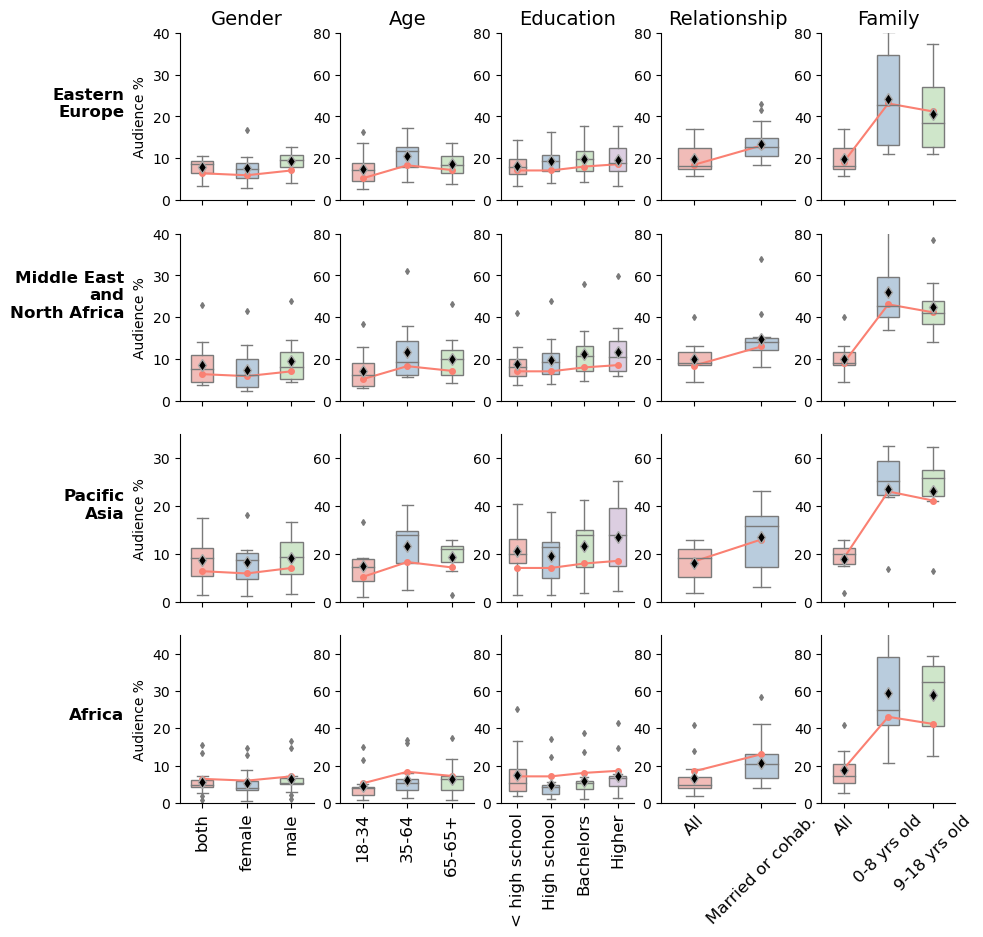

In [40]:
fig, axes = plt.subplots(4,5)
fig.set_size_inches(10,10)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
rows = ['EEU', 'MEA', 'PAS', 'AFR']
columns = ['genders', 'ages_ranges', 'scholarities', 'relationship_statuses', 'family_statuses']
lims = {'EEU' : [0,80],
        'MEA' : [0,80],
       'PAS' : [0,70],
       'AFR' : [0,90]}

row_names = {'EEU' : 'Eastern\nEurope',
        'MEA' : 'Middle East\nand\nNorth Africa',
       'PAS' : 'Pacific\nAsia',
       'AFR' : 'Africa'}

for j, col in enumerate(columns):
    for i, row in enumerate(rows):
        dfp = dfs[col][0]
        dfplot = dfp[dfp['subregion']==row]
        axes[i,j] = sns.boxplot(ax=axes[i,j], x=col, y="ac_fr", 
                 data=dfplot, linewidth=1, width=0.5, palette='Pastel1',
                 showmeans=True, meanprops={"marker":"d","markerfacecolor":"black", "markeredgecolor":"darkgrey", 
                                            "markersize":6}, fliersize=3)
        
        
        axes[i,j].set_ylim(lims[row])

        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        sns.despine(left=False, right=True, top=True) 
        if i==0:
            axes[0,j].set_title(dfs[col][1], fontsize=14)
            
        if j==0:
            axes[i, 0].set_ylabel("Audience %", fontsize=10)
            ymax = axes[i,0].get_ylim()[1]
            ymin = axes[i,0].get_ylim()[0]
            xmin = axes[i,0].get_xlim()[0]
            
            axes[i,0].text(xmin-1.25, (ymax+ymin)/2, row_names[row], fontsize=12, ha='right', fontweight='bold',)
            
            if row=='EEU':
                axes[i,j].set_yticklabels([0, 10, 20, 30 ,40])
            else:
                axes[i,j].set_yticklabels([0, 10, 20, 30 ,40, 50,60])
        if i==3:
            if col in ['genders', 'ages_ranges']:
                axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), fontsize=12, rotation=90)
            elif col=='scholarities':
                axes[i,j].set_xticklabels(['< high school', 'High school', 'Bachelors', 'Higher'], fontsize=12, rotation=90)
            elif col=='relationship_statuses':
                axes[i,j].set_xticklabels(['All', 'Married or cohab.'], fontsize=12, rotation=45)
            elif col == 'family_statuses':
                axes[i,j].set_xticklabels(['All', '0-8 yrs old', '9-18 yrs old'], fontsize=12, rotation=45)
        else:
            axes[i,j].set_xticklabels([])
            
        categories = sorted(list(set(dfplot[col])))
        xs = range(len(categories))
        ys = []
        for category in categories:
            if col != 'family_statuses':
                ys.append(df_stat[(df_stat['attribute']==col)&(df_stat['range']==category)&(df_stat['region']=='all')]['mean'])
            else:
                ys.append(dffamb[dffamb['family_statuses']==category]['ac_fr'].mean())
   
        axes[i,j].plot(xs, ys, color='salmon', linestyle='-', marker='o', markersize='4')
        #if i==3 and j in [0, 1, 2, 3]:
        #    axes[i,j].set_ylim(axes[i-1,j].get_ylim()) 
            
       
plt.savefig(directory+'global/selected_4countries_avg.pdf', dpi=300, bbox_inches='tight')    
plt.show()

In [39]:
dfpen = pd.read_excel(directory+'global/airco_penetration.xlsx')

In [44]:
dfpen.set_index('country', inplace=True)
dfpen['subregion'] = df_regions['region_gea']

In [48]:
dfpen.head()

,dau_audience,population,penetration,subregion
country,,,,
United Arab Emirates,6500599,9890400,101.108145,MEA
Afghanistan,1723852,38928341,10.532172,SAS
Albania,1130879,2837743,56.382837,EEU
Armenia,1266085,2963234,57.369752,FSU
Angola,877645,32866268,7.302320,AFR


In [49]:
reg_pen = pd.DataFrame(index=rows, columns=['mean', 'reg_tot'])
for reg in rows:
    reg_pen.loc[reg, 'mean'] = dfpen[dfpen['subregion']==reg]['penetration'].mean()
    reg_pen.loc[reg, 'reg_tot'] = dfpen[dfpen['subregion']==reg]['dau_audience'].sum() / dfpen[dfpen['subregion']==reg]['population'].sum()

In [50]:
reg_pen

,mean,reg_tot
EEU,57.275753,0.415937
MEA,65.845012,0.368484
PAS,55.122645,0.378024
AFR,15.44393,0.057622


### Which regression is the best?

In [80]:
import statsmodels.api as sm

lin_rmse = {}
df = df_macro.copy()
models = {}

In [99]:
attribute = 'gdp pc'
df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
xmax = df[attribute].max()
xmin = df[attribute].min()

for region, color in color_dic.items():
    dfp = df[df['region']==region].copy()
    n = dfp.shape[0]

    #normalize
    dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
    dfp['ac_fr'] = 100 * dfp['ac_fr']

    x = dfp['x']
    y = dfp['ac_fr']

    model = sm.OLS(y, x).fit()
    ypred = model.predict(x)
    error = ypred - y
    #RMSE = np.sqrt((( y - ypred)**2).values.mean())
    lin_rmse[(attribute, region)] = model.rsquared
    models[('lin',attribute, region)] = model

    #plt.scatter(x,y)
    #plt.plot(x,ypred)

In [106]:
pol_rmse = {}
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

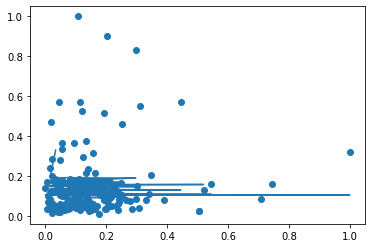

In [147]:
attribute = 'gdp pc'
df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
xmax = df[attribute].max()
xmin = df[attribute].min()
deg = 4
polynomial_features= PolynomialFeatures(degree=deg)

for region in ['south']:#, color in color_dic.items():
    dfp = df[df['region']==region].copy()
    n = dfp.shape[0]

    #normalize
    dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
    dfp['ac_fr'] = dfp['ac_fr'] / dfp['ac_fr'].max()

    x = dfp['x']
    y = dfp['ac_fr'] 
    x =  np.array(x).reshape(-1,1)
    y =  np.array(y).reshape(-1,1)
    
    xpol = polynomial_features.fit_transform(x)
    lin2 = LinearRegression()
    lin2.fit(xpol, y)

    #model = sm.OLS(y, xpol).fit()
    #ypred = model.predict(x)
    #error = ypred - y
    #RMSE = np.sqrt((( y - ypred)**2).mean())
    
    pol_rmse[(deg, attribute, region)] = model.rsquared
    models[('pol2',attribute, region)] = model
    
    
    flat_list_x = [item for sublist in x for item in sublist]
    x_new = list(set(flat_list_x))

    yy = lin2.predict(polynomial_features.fit_transform(x))
    flat_list_y = [item for sublist in yy for item in sublist]
    y_new = sorted(list(set(flat_list_y)))
    plt.scatter(x,y)
    plt.plot(x_new,y_new)

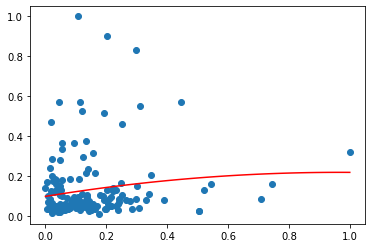

In [150]:
mymodel = np.poly1d(np.polyfit(dfp['x'], dfp['ac_fr'],2))
plt.scatter(x,y)
x_n = np.linspace(0, 1, 100)
plt.plot(x_n, mymodel(x_n), color='red')

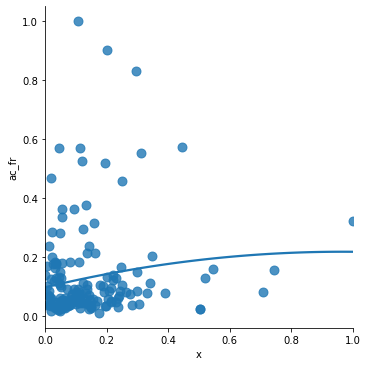

In [149]:
sns.lmplot(x="x", y="ac_fr", data=dfp, order=2,
           ci=None, scatter_kws={"s": 80});

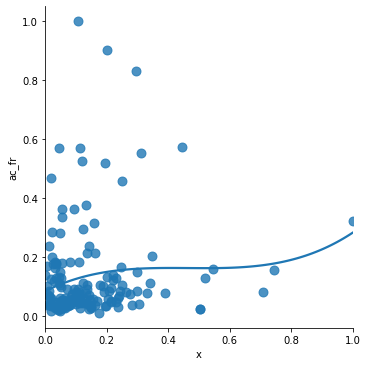

In [151]:
sns.lmplot(x="x", y="ac_fr", data=dfp, order=3,
           ci=None, scatter_kws={"s": 80});

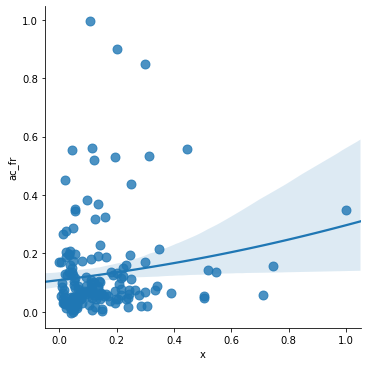

In [152]:
sns.lmplot(x="x", y="ac_fr", data=dfp, logistic=True, y_jitter=.03,truncate=False, scatter_kws={"s": 80})

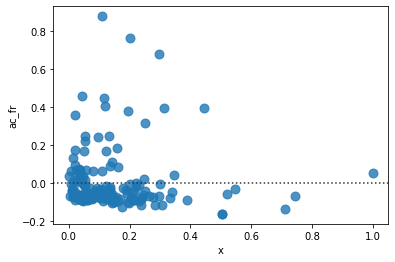

In [158]:
sns.residplot(x="x", y="ac_fr", data=dfp,
              scatter_kws={"s": 80});

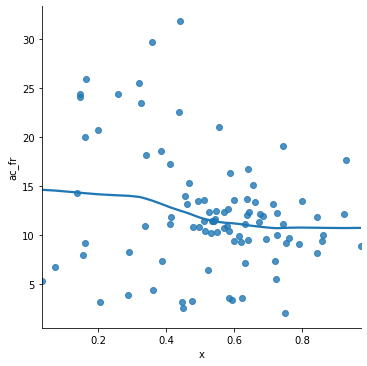

In [135]:
sns.lmplot(x="x", y="ac_fr", data=dfp, lowess=True, )

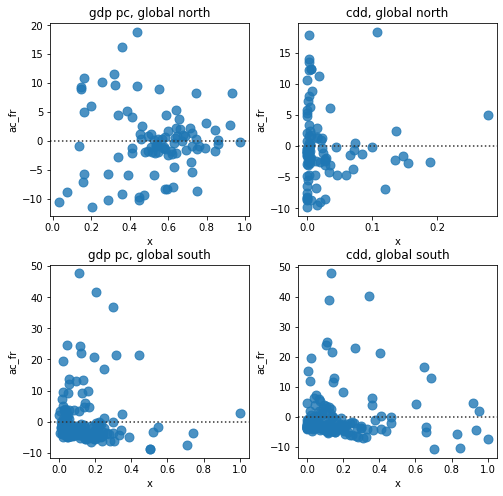

In [165]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(8,8)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
j=0
for attribute in ['gdp pc', 'cdd']:
    df = df[(~df[attribute].isna())&(~df['ac_fr'].isna())]
    xmax = df[attribute].max()
    xmin = df[attribute].min()
    i=0
    for region, color in color_dic.items():
        dfp = df[df['region']==region].copy()
        n = dfp.shape[0]

        #normalize
        dfp['x'] = (dfp[attribute]-xmin) / (xmax-xmin)
        dfp['ac_fr'] = 100 * dfp['ac_fr']

        axes[i,j] = sns.residplot(x="x", y="ac_fr", data=dfp,
              scatter_kws={"s": 80}, ax = axes[i,j])
        axes[i,j].set_title(attribute+', global '+region)
        i+=1
    j+=1
plt.savefig(directory+"global/linreg_residuals.png", dpi=300, bbox_inches='tight')    
plt.show()